## EMA_MACD_TXF_1D_STRATEGY ##

In [380]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import math
import statistics
import zipfile
import seaborn as sns
import talib
from datetime import datetime
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('ggplot')

In [381]:
data=pd.read_csv('/Users/laiguanyu/Documents/python_/TXF1-分鐘-成交價.txt')

In [382]:
data=data.rename(columns=dict(zip(data.columns,["Date","Time","open","high","low","close","volume"])))
data.Date=pd.to_datetime(data.Date)
data.Time=pd.to_timedelta(data.Time)
data=data.set_index((data.Date+data.Time)).drop(['Date','Time'],axis=1)

In [383]:
df=data.resample("1d").agg(dict(zip(data.columns,["first","max","min","last","sum"]))).dropna()#,"first"

df["weekday"]=df.index.map(lambda x : x.weekday + 1)
df["Year"]   =df.index.map(lambda x : x.year)

In [384]:
df1=df[df["Year"] <  2017]
df2=df[df["Year"] >= 2017]

## training testing set ##

In [385]:
df1 = df1.drop(["Year"],axis= 1)
df2 = df2.drop(["Year"],axis= 1)

## Tech Index ##

In [386]:
##EMA
N1=5
N2=60
df_EMA=pd.DataFrame({"Fast_ema":df.close.ewm(span=N1).mean(),"Slow_ema":df.close.ewm(span=N2).mean()})
df_EMA1=df_EMA[df_EMA.index.year <  2017]
df_EMA2=df_EMA[df_EMA.index.year >= 2017]

In [387]:
##MACD
from talib import abstract
df_MACD=abstract.MACD(df,fastperiod=N1,Slowperiod=N2).dropna()
df_MACD1=df_MACD[df_MACD.index.year <  2017]
df_MACD2=df_MACD[df_MACD.index.year >= 2017]
#macd 快 signal 慢 

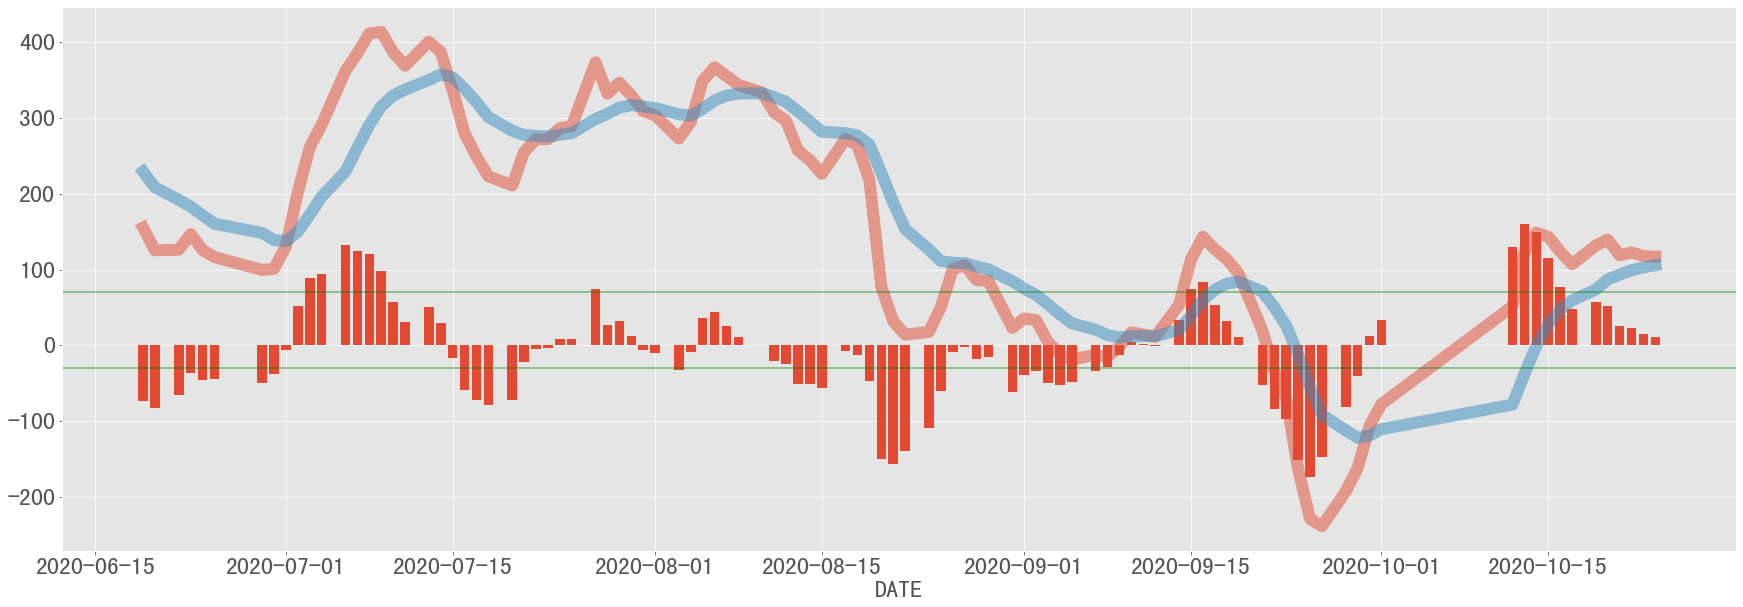

In [388]:
plt.figure(figsize=(30,10))
plt.bar (x=df_MACD.index[-100:],height=df_MACD["macdhist"][-100:],label="DIFF")
plt.plot(df_MACD["macd"][-100:],alpha=0.5,label="MACD",linewidth=12)
plt.plot(df_MACD["macdsignal"][-100:],alpha=0.5,label="SIGNAL",linewidth=12)
plt.xlabel("DATE",fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.axhline(y= 70,color="green",alpha=0.5,drawstyle='steps')
plt.axhline(y=-30,color="green",alpha=0.5,drawstyle='steps')
for i ,ticks in enumerate(plt.yticks()):
    if i % 2 != 0:
        ticks = ""
ax.legend(loc="upper right",fontsize=24)

## Signal Setting traning ##

In [389]:
df_EMA_MACD_1=pd.concat([df_EMA1,df_MACD1,df1.close,df1.weekday],axis=1,join="inner")
df_EMA_MACD_1=df_EMA_MACD_1.rename(columns=dict(zip(df_EMA_MACD_1.columns,["Fast_EMA","Slow EMA","Fast_MACD","Slow_MACD","DIFF","close","weekday"])))
df_EMA_MACD_1["DayofMonth"]=df_EMA_MACD_1.index.map(lambda x:x.day)

In [390]:
EMA_F=df_EMA_MACD_1["Fast_EMA"]
EMA_S=df_EMA_MACD_1["Slow EMA"]
MACD_F=df_EMA_MACD_1["Fast_MACD"]
MACD_S=df_EMA_MACD_1["Slow_MACD"]
Price =df_EMA_MACD_1["close"]

In [391]:
signal =np.where((Price>EMA_F) & (MACD_F>MACD_S) , 1, 0)
signal2=np.where((Price<EMA_F) & (MACD_F<MACD_S) ,-1, 0)

signal_long =pd.Series(signal,index=df_EMA_MACD_1.index)
signal_Short=pd.Series(signal2,index=df_EMA_MACD_1.index)

In [404]:
###NEED TO CHANGE
signal_all = signal_long+signal_Short
signal_all = signal_all.to_frame(name="signal")
###NEED TO CHANGE
###轉倉
signal_all["D"]=signal_all.index.map(lambda x : x.weekday )
signal_all["D2"]=signal_all.index.map(lambda x : x.day )
for i in range(len(signal_all)):
    if (signal_all["D"][i] == 3 ) & (21>=signal_all["D2"][i]) & (signal_all["D2"][i]>14):
        signal_all["signal"][i] = 0
signal_all = signal_all.drop(["D","D2"],axis=1)

pandas.core.series.Series

In [457]:
return_df["Long Signal" ]=signal_long
return_df["Short Signal"]=signal_Short
return_df["Long_Return"]=return_df["Percent Change"]*return_df[ "Long Signal"]
return_df["Short_Return"]=return_df["Percent Change"]*return_df["Short Signal"]
print(return_df["Long_Return"].sum()+return_df["Short_Return"].sum())

24.058126067514298


In [439]:
#return_df = pd.concat([df_EMA_MACD_1.close.pct_change() , signal_all.shift(2)],axis=1).dropna()
#return_df.columns=["Percent Change","Signal"]
#return_df["Return"]=return_df["Percent Change"]*return_df["Signal"]
#print(return_df["Return"].sum())
#print(return_df["Return"].cumsum().dropna()[-1])

0.08289555249791347
0.08289555249791347


## Profit Analysis ## 

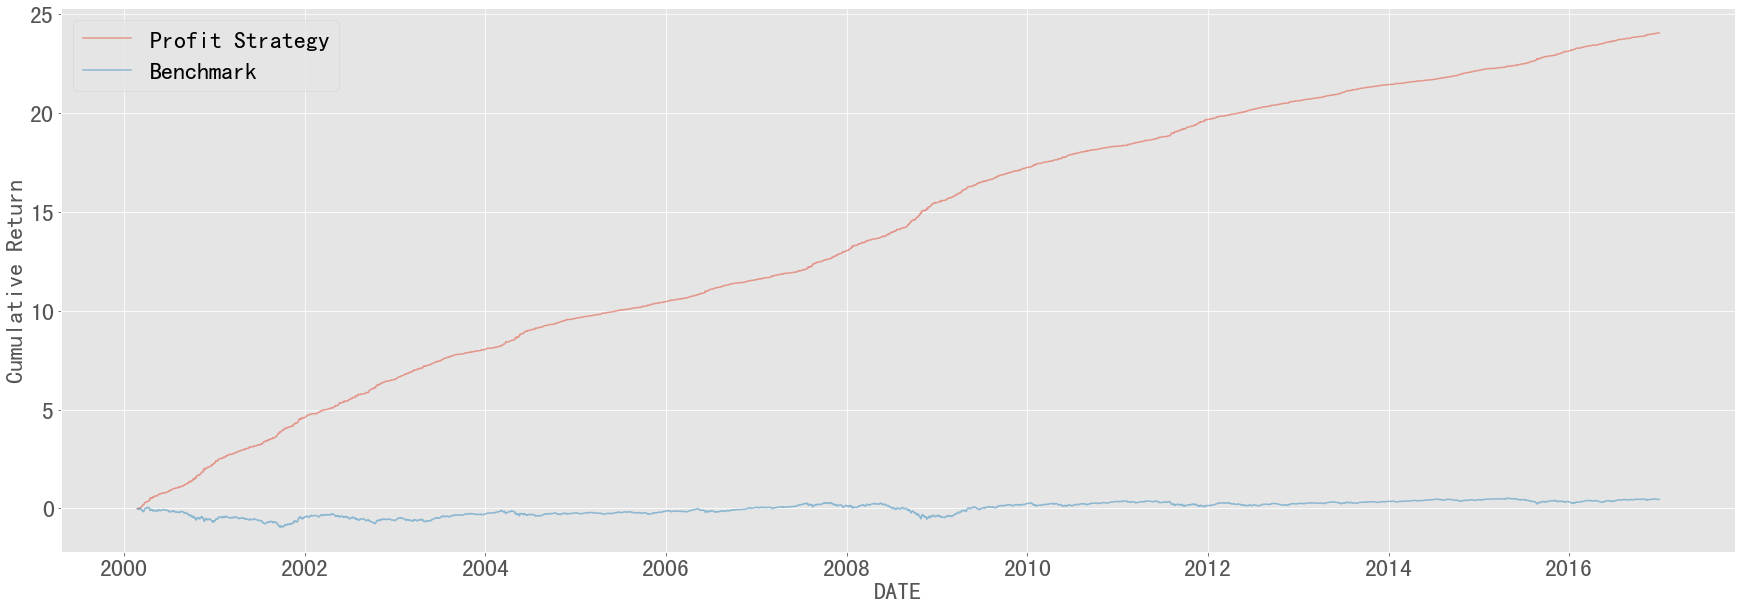

In [458]:
plt.figure(figsize = (30,10))
plt.plot(return_df["Long_Return"].cumsum()+return_df["Short_Return"].cumsum(), alpha = 0.5, label = 'Profit Strategy')
plt.plot(df_EMA_MACD_1.close.pct_change().dropna().cumsum(), alpha = 0.5, label = 'Benchmark')
plt.ylabel('Cumulative Return',fontsize=24)
plt.xlabel("DATE",fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

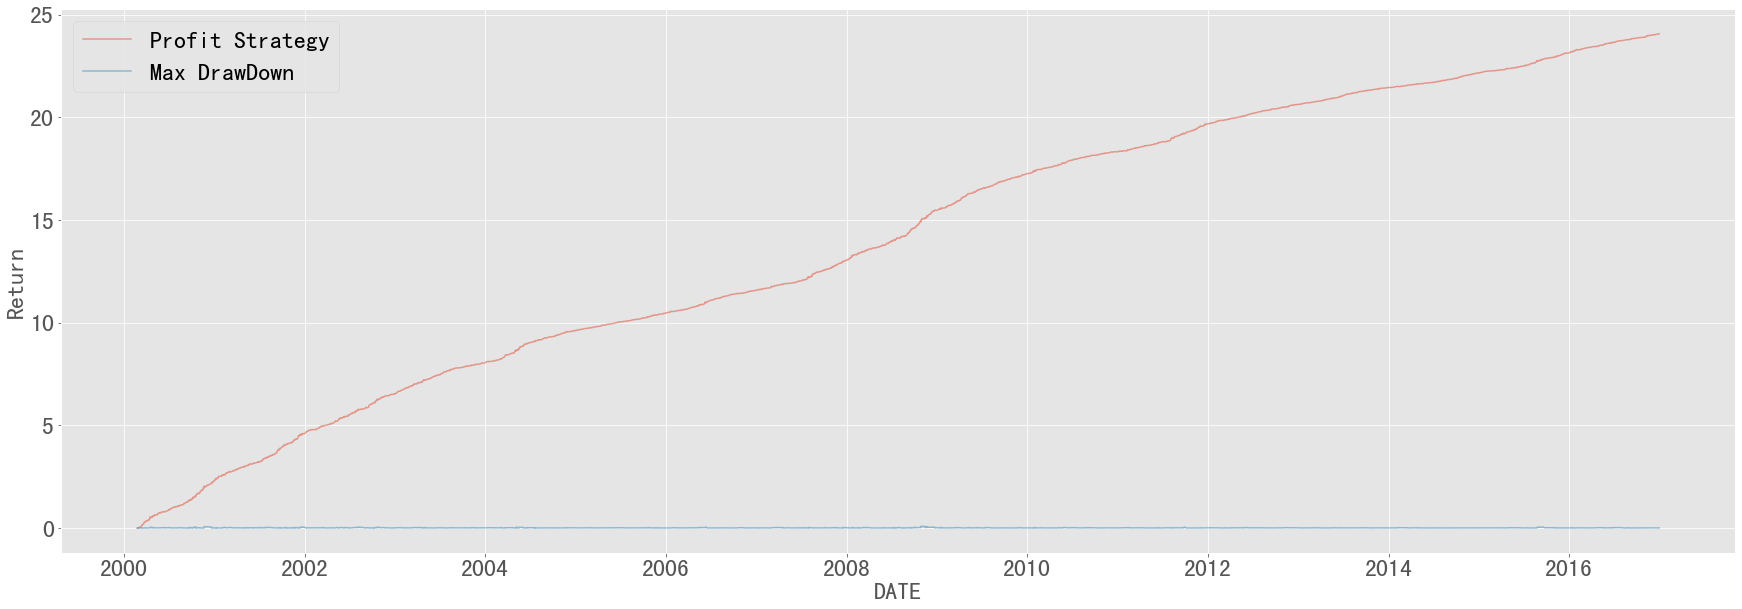

In [459]:
MDD_Series = (return_df.Long_Return.cumsum().cummax()-return_df.Long_Return.cumsum())+(return_df.Short_Return.cumsum().cummax()-return_df.Short_Return.cumsum())
MDD =max(MDD_Series)
plt.figure(figsize = (30,10))
plt.plot(return_df["Long_Return"].cumsum()+return_df["Short_Return"].cumsum(), alpha = 0.5, label = 'Profit Strategy')
plt.plot(MDD_Series, alpha = 0.5, label = 'Max DrawDown')
plt.ylabel('Return',fontsize=24)
plt.xlabel("DATE",fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

In [467]:
Return_on_MDD=(return_df["Long_Return"].sum()+return_df["Short_Return"].sum())/MDD
print("The Strategy MDD : %f \nthe Return_on_MDD : %f"%(MDD,Return_on_MDD))

The Strategy MDD : 0.093609 
the Return_on_MDD : 257.005563


## Return on Long/Short Position ##

In [454]:
return_df["Long Signal" ]=signal_long
return_df["Short Signal"]=signal_Short
return_df["Long_Return"]=return_df["Percent Change"]*return_df[ "Long Signal"]
return_df["Short_Return"]=return_df["Percent Change"]*return_df["Short Signal"]

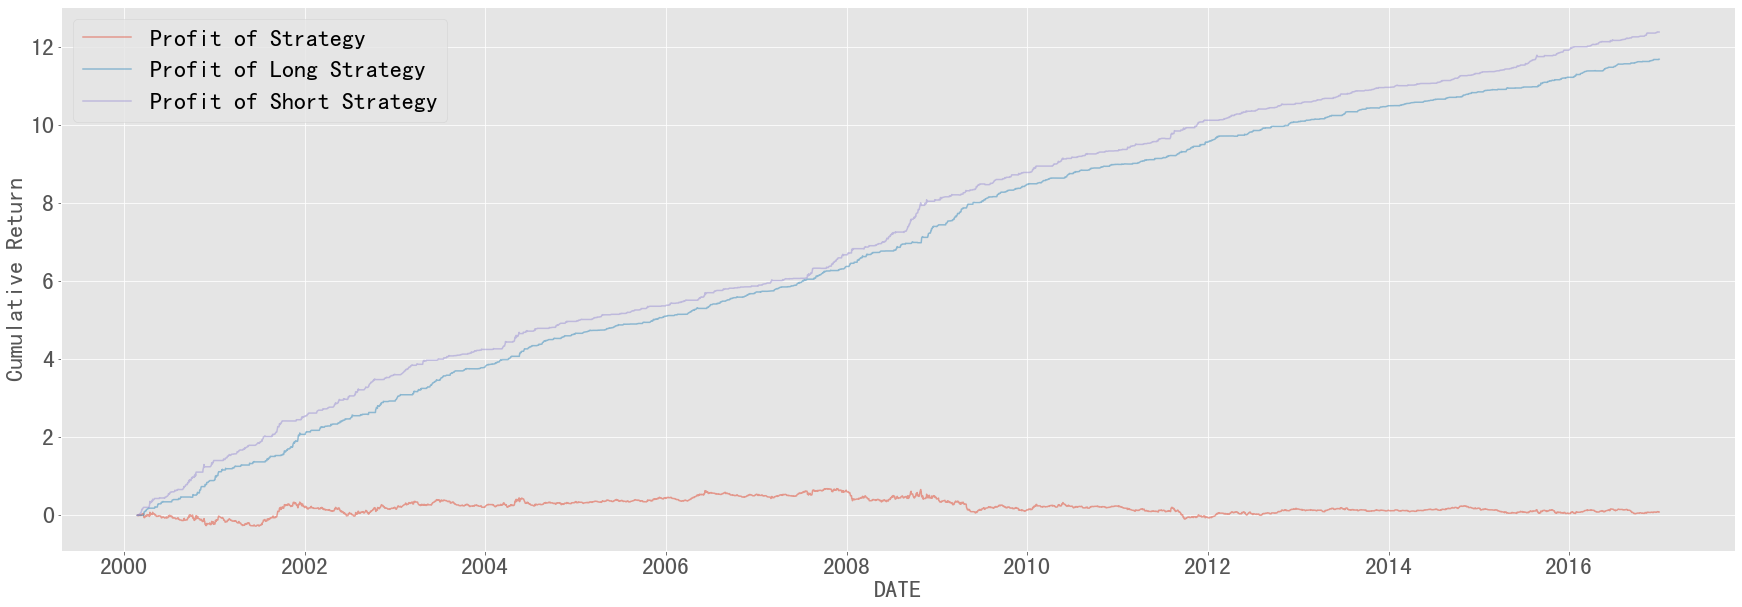

In [455]:
plt.figure(figsize = (30,10))
plt.plot(return_df['Return'].dropna().cumsum(), alpha = 0.5, label = 'Profit of Strategy')
plt.plot(return_df['Long_Return'].dropna().cumsum(), alpha = 0.5, label = 'Profit of Long Strategy')
plt.plot(return_df['Short_Return'].dropna().cumsum(), alpha = 0.5,label = 'Profit of Short Strategy')
plt.ylabel('Cumulative Return',fontsize=24)
plt.xlabel("DATE",fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)

## Optimal ##

In [476]:
x_sma = []
y_lma = []
z_RonMDD = []
w_Return = []
for i in range(5,45,5):
    for j in range(60,125,5):
        N1=i
        N2=j
        df_EMA=pd.DataFrame({"Fast_ema":df.close.ewm(span=N1).mean(),"Slow_ema":df.close.ewm(span=N2).mean()})
        df_EMA1=df_EMA[df_EMA.index.year <  2017]
        df_EMA2=df_EMA[df_EMA.index.year >= 2017]
        
        df_MACD=abstract.MACD(df,fastperiod=N1,Slowperiod=N2).dropna()
        df_MACD1=df_MACD[df_MACD.index.year <  2017]
        df_MACD2=df_MACD[df_MACD.index.year >= 2017]
        
        df_EMA_MACD_1=pd.concat([df_EMA1,df_MACD1,df1.close,df1.weekday],axis=1,join="inner")
        df_EMA_MACD_1=df_EMA_MACD_1.rename(columns=dict(zip(df_EMA_MACD_1.columns,["Fast_EMA","Slow EMA","Fast_MACD","Slow_MACD","DIFF","close","weekday"])))
        df_EMA_MACD_1["DayofMonth"]=df_EMA_MACD_1.index.map(lambda x:x.day)
        
        EMA_F=df_EMA_MACD_1["Fast_EMA"]
        EMA_S=df_EMA_MACD_1["Slow EMA"]
        MACD_F=df_EMA_MACD_1["Fast_MACD"]
        MACD_S=df_EMA_MACD_1["Slow_MACD"]
        Price =df_EMA_MACD_1["close"]
        
        signal =np.where((Price>EMA_F) & (MACD_F>MACD_S) , 1, 0)
        signal2=np.where((Price<EMA_F) & (MACD_F<MACD_S) ,-1, 0)

        signal_long =pd.Series(signal,index=df_EMA_MACD_1.index)
        signal_Short=pd.Series(signal2,index=df_EMA_MACD_1.index)
###NEED TO CHANGE
        signal_all = signal_long+signal_Short
        signal_all = signal_all.to_frame(name="signal")
###NEED TO CHANGE
###轉倉
#        signal_all["D"]=signal_all.index.map(lambda x : x.weekday )
#        signal_all["D2"]=signal_all.index.map(lambda x : x.day )
#        for i in range(len(signal_all)):
#            if (signal_all["D"][i] == 3 ) & (21>=signal_all["D2"][i]) & (signal_all["D2"][i]>14):
#                signal_all["signal"][i] = 0
#                signal_all = signal_all.drop(["D","D2"],axis=1)
###此段目前無效
        return_df["Long Signal" ]=signal_long
        return_df["Short Signal"]=signal_Short
        return_df["Long_Return"]=return_df["Percent Change"]*return_df[ "Long Signal"]
        return_df["Short_Return"]=return_df["Percent Change"]*return_df["Short Signal"]

        MDD_Series = (return_df.Long_Return.cumsum().cummax()-return_df.Long_Return.cumsum())+(return_df.Short_Return.cumsum().cummax()-return_df.Short_Return.cumsum())
        MDD =max(MDD_Series)
        Return_on_MDD=(return_df["Long_Return"].sum()+return_df["Short_Return"].sum())/MDD

        x_sma.append(i)
        y_lma.append(j)
        z_RonMDD.append(Return_on_MDD)
        w_Return.append(return_df["Long_Return"].sum()+return_df["Short_Return"].sum())
        #print(z_RonMDD)
    
#fig = plt.figure(figsize = (30,20))
#ax = fig.gca(projection='3d')
#ax.plot_trisurf(x_sma, y_lma, z_RonMDD, cmap=plt.cm.viridis, linewidth=0.2)
#ax.set_xlabel('SMA')
#ax.set_ylabel('LMA')
#ax.set_zlabel('z_RonMDD')
#plt.show()